In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
import os, json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
class ParkingDataset(Dataset):
    def __init__(self, images_dir, annotations_file, transforms=None):
        self.images_dir = images_dir
        self.transforms = transforms

        # Load COCO JSON file
        with open(annotations_file) as f:
            coco_data = json.load(f)

        self.images = coco_data["images"]
        self.annotations = coco_data["annotations"]

        # Map images to their annotations
        self.image_to_anns = {img["id"]: [] for img in self.images}
        for ann in self.annotations:
            self.image_to_anns[ann["image_id"]].append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.images_dir, img_info["file_name"])
        image = read_image(img_path).float() / 255.0

        anns = self.image_to_anns[img_info["id"]]
        boxes, labels = [], []
        for ann in anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x+w, y+h])
            labels.append(1)   # class = 1 (only car)

        # If there are no boxes, return an empty target
        if len(boxes) == 0:
            target = {
                "boxes": torch.zeros((0,4), dtype=torch.float32),
                "labels": torch.zeros((0,), dtype=torch.int64),
            }
        else:
            target = {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64),
            }

        if self.transforms:
            image = self.transforms(image)

        return image, target

In [3]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [4]:
transform = None

#  Train
train_dataset = ParkingDataset(
    images_dir="/content/drive/MyDrive/mawqif.v1i.coco/train",
    annotations_file="/content/drive/MyDrive/mawqif.v1i.coco/train/_annotations.coco.json",
    transforms=transform
)

# Validation
val_dataset = ParkingDataset(
    images_dir="/content/drive/MyDrive/mawqif.v1i.coco/valid",
    annotations_file="/content/drive/MyDrive/mawqif.v1i.coco/valid/_annotations.coco.json",
    transforms=transform
)

#  Test
test_dataset = ParkingDataset(
    images_dir="/content/drive/MyDrive/mawqif.v1i.coco/test",
    annotations_file="/content/drive/MyDrive/mawqif.v1i.coco/test/_annotations.coco.json",
    transforms=transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [5]:
images, targets = next(iter(train_loader))
print(images[0].shape)
print(targets[0]["boxes"])
print(targets[0]["labels"])

torch.Size([3, 1024, 1024])
tensor([[352.0000, 752.0000, 382.0600, 801.9300],
        [312.0000, 707.0000, 349.8300, 745.4600],
        [250.0000, 647.0000, 282.8400, 671.4200],
        [274.0000, 676.0000, 314.2300, 700.3100],
        [695.0000, 747.0000, 756.5200, 783.5500],
        [681.0000, 700.0000, 728.4700, 734.1200],
        [670.0000, 648.0000, 713.9300, 675.2900],
        [663.0000, 601.0000, 715.7100, 630.8200],
        [290.0000, 412.0000, 325.2400, 432.0700],
        [325.0000, 393.0000, 359.0300, 411.4200],
        [357.0000, 374.0000, 388.6000, 391.9300],
        [387.0000, 362.0000, 414.9000, 373.8900],
        [555.0000, 220.0000, 586.6300, 230.7600],
        [562.0000, 240.0000, 584.2400, 250.7700],
        [574.0000, 255.0000, 594.6500, 264.3100],
        [575.0000, 273.0000, 602.1400, 284.0600],
        [573.0000, 288.0000, 602.1300, 296.1500],
        [575.0000, 299.0000, 602.3500, 304.5000],
        [586.0000, 310.0000, 615.1700, 315.2800],
        [598.0000, 324

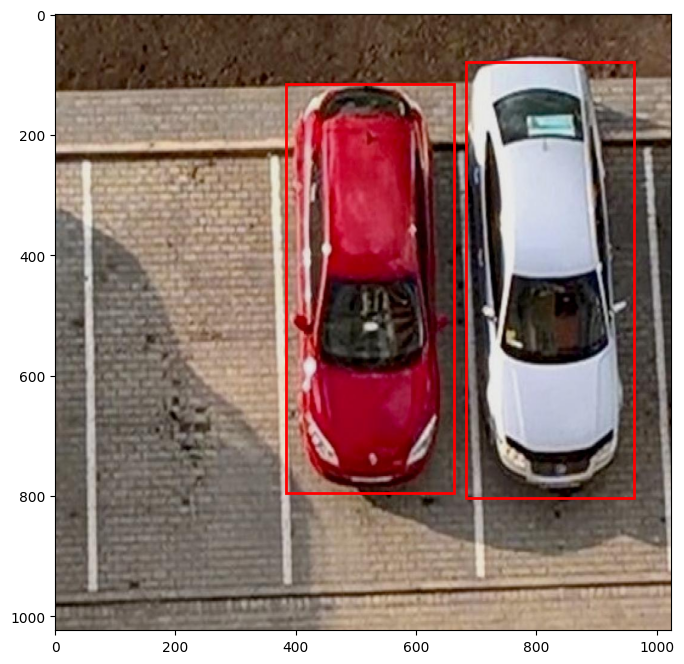

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

images, targets = next(iter(train_loader))

# Tensor → numpy [H,W,C]
img = images[0].permute(1, 2, 0).numpy()

#  target
boxes = targets[0]["boxes"]


fig, ax = plt.subplots(1, figsize=(8,8))
ax.imshow(img)

for box in boxes:
    x1, y1, x2, y2 = box
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor="r", facecolor="none"
    )
    ax.add_patch(rect)

plt.show()

In [7]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fasterrcnn_resnet50_fpn(num_classes=2)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [8]:
 #Training Loop (Adam optimizer instead of SGD)

import torch.optim as optim

# Adam instead of SGD
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)

num_epochs = 5
for ep in range(num_epochs):
    model.train()
    total_loss = 0.0

    for imgs, tgts in train_loader:
        imgs = [i.to(device) for i in imgs]
        tgts = [{k: v.to(device) for k,v in t.items()} for t in tgts]

        loss_dict = model(imgs, tgts)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Epoch {ep+1}/{num_epochs}] Train Loss: {total_loss:.4f}")

[Epoch 1/5] Train Loss: 70.4318
[Epoch 2/5] Train Loss: 64.3093
[Epoch 3/5] Train Loss: 64.2783
[Epoch 4/5] Train Loss: 56.1278
[Epoch 5/5] Train Loss: 51.4767


In [ ]:
#⁠ ⁠Validation Check (after each training)

model.eval()
val_loss = 0.0
with torch.no_grad():
    for imgs, tgts in val_loader:
        imgs = [i.to(device) for i in imgs]
        tgts = [{k: v.to(device) for k,v in t.items()} for t in tgts]

        out = model(imgs, tgts)
        loss = sum(out.values())
        val_loss += loss.item()

print(f"Validation Loss: {val_loss:.4f}")

In [ ]:
 #Training Loop (Adam optimizer instead of SGD)

import torch.optim as optim

# Adam instead of SGD
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)

num_epochs = 5
for ep in range(num_epochs):
    model.train()
    total_loss = 0.0

    for imgs, tgts in train_loader:
        imgs = [i.to(device) for i in imgs]
        tgts = [{k: v.to(device) for k,v in t.items()} for t in tgts]

        loss_dict = model(imgs, tgts)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Epoch {ep+1}/{num_epochs}] Train Loss: {total_loss:.4f}")

[Epoch 1/5] Train Loss: 70.4318
[Epoch 2/5] Train Loss: 64.3093
[Epoch 3/5] Train Loss: 64.2783
[Epoch 4/5] Train Loss: 56.1278
[Epoch 5/5] Train Loss: 51.4767


In [10]:
#Validation Check (after each training)

val_loss = 0.0
model.train()
with torch.no_grad():
    for imgs, tgts in val_loader:
        imgs = [i.to(device) for i in imgs]
        tgts = [{k: v.to(device) for k,v in t.items()} for t in tgts]

        out = model(imgs, tgts)
        loss = sum(out.values())
        val_loss += loss.item()

print(f"Validation Loss: {val_loss:.4f}")

Validation Loss: 17.5410


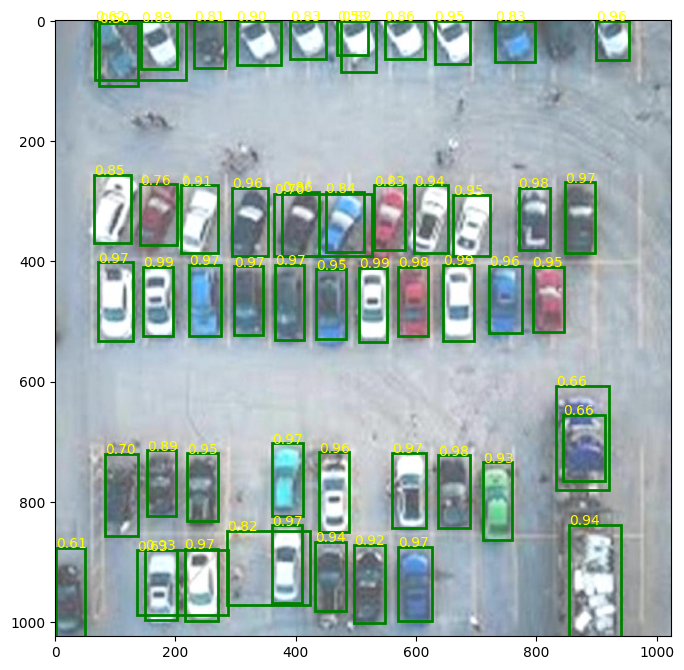

In [15]:
# ⁠ ⁠Inference + Visualization (Validation image)

model.eval()
imgs, tgts = next(iter(val_loader))
img = imgs[3].to(device)

with torch.no_grad():
    pred = model([img])[0]

img_np = img.permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, figsize=(8,8))
ax.imshow(img_np)

for box, score in zip(pred["boxes"], pred["scores"]):
    if score > 0.5:
        x1,y1,x2,y2 = box.cpu().numpy()
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                 linewidth=2, edgecolor="g", facecolor="none")
        ax.add_patch(rect)
        ax.text(x1, y1, f"{score:.2f}", color="yellow")

plt.show()

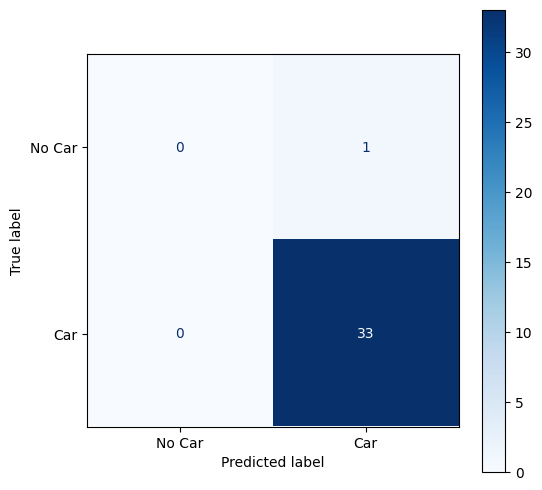

In [16]:
#⁠ ⁠Confusion Matrix (Test dataset)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for imgs, tgts in test_loader:
        imgs = [i.to(device) for i in imgs]
        outs = model(imgs)

        for t, o in zip(tgts, outs):
            y_true.append(0 if len(t["boxes"]) == 0 else 1)
            conf = o["scores"].max().item() if len(o["scores"])>0 else 0
            y_pred.append(1 if conf > 0.5 else 0)

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["No Car","Car"])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap="Blues", ax=ax, values_format="d")
plt.show()

In [17]:
torch.save(model.state_dict(), "faster_rcnn_car.pth")